# MLP cross validation
Classify pc vs nc RNA.

Set aside the 20% test set, stratified by length.
On the remaining 80%,
perform 5-fold cross validation.

MLP_04 only ran this on the 1KB-2KB subset.
but varied the size of K i.e. K=2,3,4.

Here, use K=3 and test various subsets 
of sequence by length as well as the full set.

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit


# For cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# For the manual cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

tf.keras.backend.set_floatx('float32')

In [2]:
# Expect CSV file with these columns (for K=2)
# seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
def read_features(nc_file,pc_file):
    nc = pd.read_csv (nc_file)
    pc = pd.read_csv (pc_file)
    nc['class']=0
    pc['class']=1
    rna_mer=pd.concat((nc,pc),axis=0)
    return rna_mer

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

# Normalize: K-mer frequency = K-mer count / seqlen
# Put label in y. Remove all but the frequencies from X.
def prepare_data_set(data):
    y_test=   data[['class']].copy()
    X_test=   data.div(data['seqlen'],axis=0).drop(columns=['class','seqnum','seqlen'])
    return (X_test,y_test)

def subset(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [3]:
def do_cross_validation(X,y):
    cv_scores = []
    act="sigmoid"
    dt='float32'
    fold=0
    eps=100
    splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        X_train=X.iloc[train_index]
        y_train=y.iloc[train_index]
        X_valid=X.iloc[valid_index]
        y_valid=y.iloc[valid_index]
        mlp = keras.models.Sequential([
            keras.layers.LayerNormalization(trainable=False),
            keras.layers.Dense(32, activation=act,dtype=dt),
            keras.layers.Dense(32, activation=act,dtype=dt),
            keras.layers.Dense(1,  activation=act,dtype=dt)
        ])
        bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
        mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
        history=mlp.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = mlp.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (mlp.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


## K-mer frequency, K=3, size 200-1Kb

original (30290, 67)
no short (30290, 67)
no long, no short (8879, 67)
(8879, 64) (8879, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 1, 100 epochs


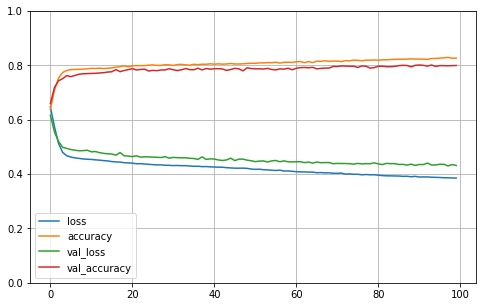

accuracy: 79.95%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 2, 100 epochs


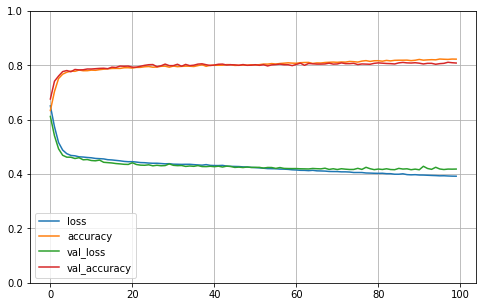

accuracy: 80.86%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 3, 100 epochs


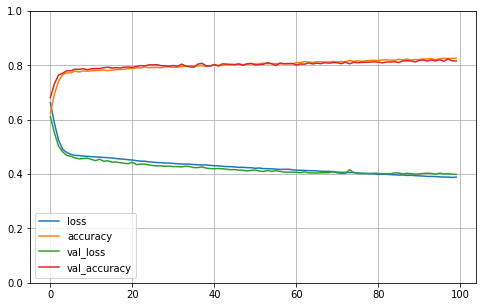

accuracy: 81.64%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 4, 100 epochs


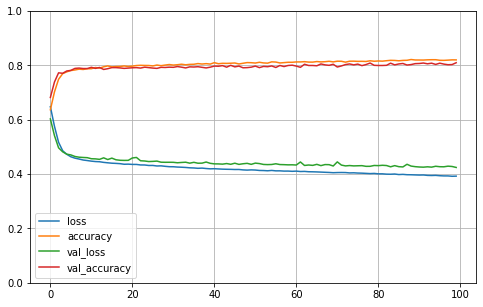

accuracy: 80.97%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 5, 100 epochs


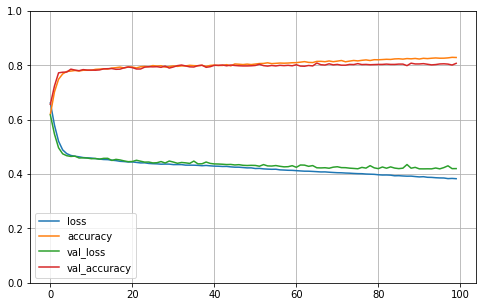

accuracy: 80.74%

Validation core mean 80.83% (+/- 0.54%)


In [4]:
rna_mer = read_features('ncRNA.3mer.features.csv','pcRNA.3mer.features.csv')
(train_set,test_set)=make_train_test(rna_mer)
(X_test,y_test)=prepare_data_set(test_set)
train_set=subset(train_set,200,1000)
(X_train_all,y_train_all)=prepare_data_set(train_set)
print(X_train_all.shape,y_train_all.shape)
do_cross_validation(X_train_all,y_train_all)

## K-mer frequency, K=3, size 1Kb-2Kb

original (30290, 67)
no short (9273, 67)
no long, no short (3368, 67)
(3368, 64) (3368, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 1, 100 epochs


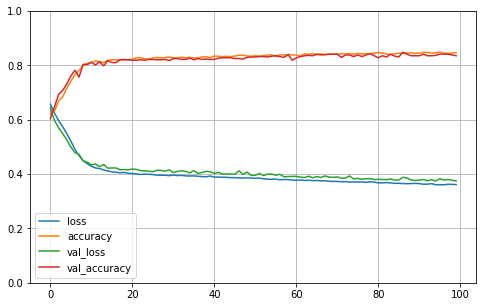

accuracy: 83.53%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 2, 100 epochs


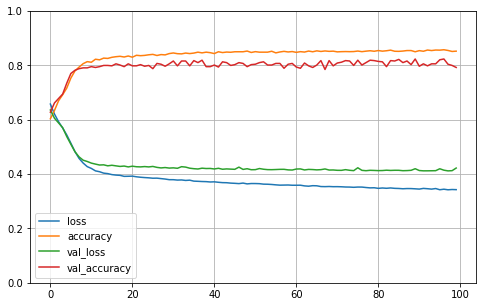

accuracy: 79.23%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 3, 100 epochs


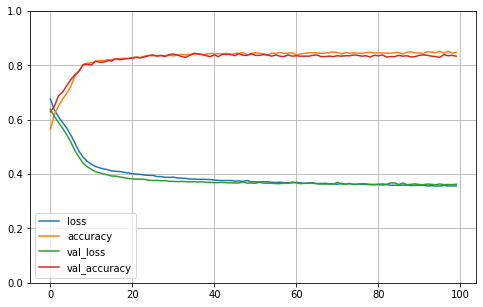

accuracy: 83.38%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 4, 100 epochs


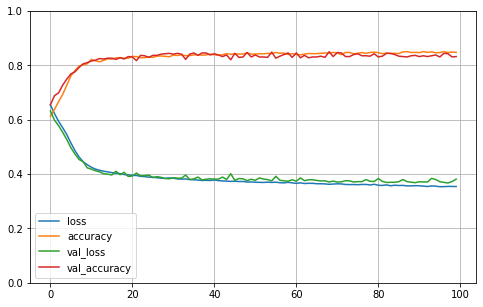

accuracy: 83.23%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 5, 100 epochs


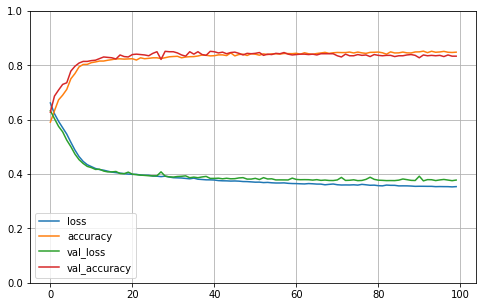

accuracy: 83.38%

Validation core mean 82.55% (+/- 1.66%)


In [5]:
rna_mer = read_features('ncRNA.3mer.features.csv','pcRNA.3mer.features.csv')
(train_set,test_set)=make_train_test(rna_mer)
(X_test,y_test)=prepare_data_set(test_set)
train_set=subset(train_set,1000,2000)
(X_train_all,y_train_all)=prepare_data_set(train_set)
print(X_train_all.shape,y_train_all.shape)
do_cross_validation(X_train_all,y_train_all)

## K-mer frequency, K=3, size 2Kb-3Kb

original (30290, 67)
no short (3221, 67)
no long, no short (1351, 67)
(1351, 64) (1351, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 1, 100 epochs


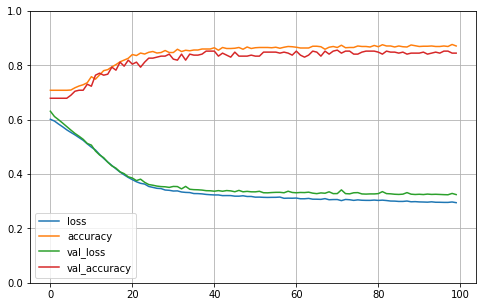

accuracy: 84.50%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 2, 100 epochs


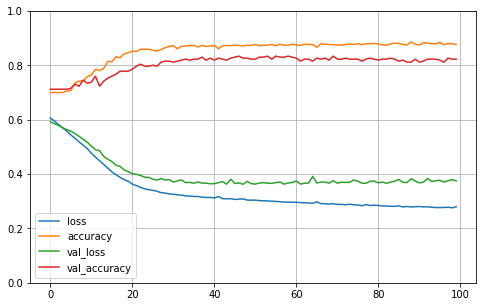

accuracy: 82.29%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 3, 100 epochs


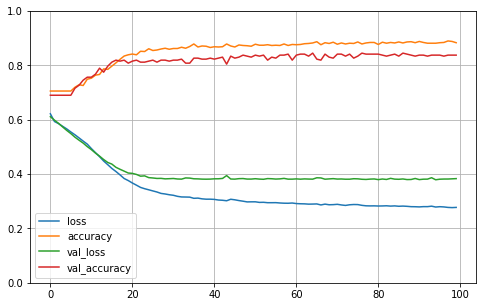

accuracy: 83.76%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 4, 100 epochs


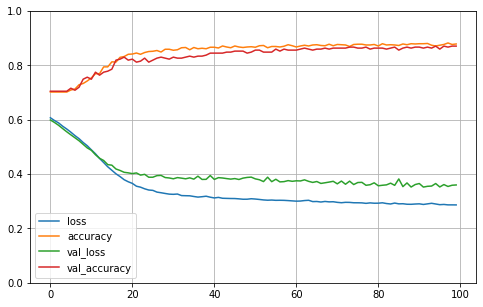

accuracy: 87.08%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 5, 100 epochs


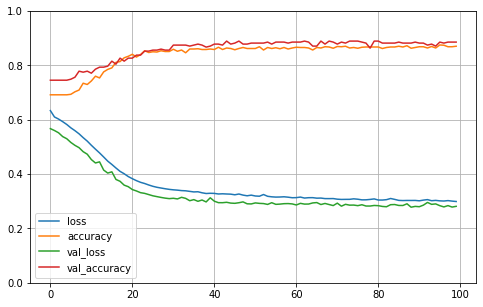

accuracy: 88.56%

Validation core mean 85.24% (+/- 2.27%)


In [6]:
rna_mer = read_features('ncRNA.3mer.features.csv','pcRNA.3mer.features.csv')
(train_set,test_set)=make_train_test(rna_mer)
(X_test,y_test)=prepare_data_set(test_set)
train_set=subset(train_set,2000,3000)
(X_train_all,y_train_all)=prepare_data_set(train_set)
print(X_train_all.shape,y_train_all.shape)
do_cross_validation(X_train_all,y_train_all)

## K-mer frequency, K=3, size 200-3Kb

original (30290, 67)
no short (30290, 67)
no long, no short (24048, 67)
(24048, 64) (24048, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 1, 100 epochs


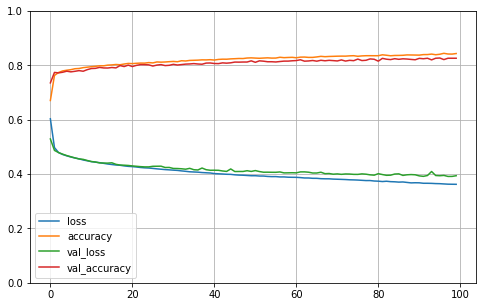

accuracy: 82.62%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 2, 100 epochs


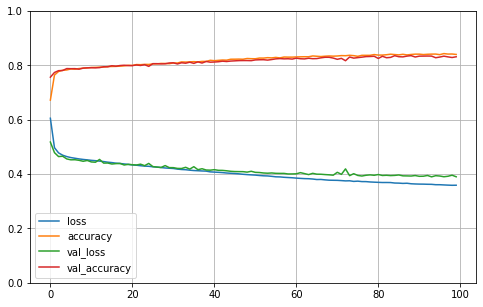

accuracy: 83.16%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 3, 100 epochs


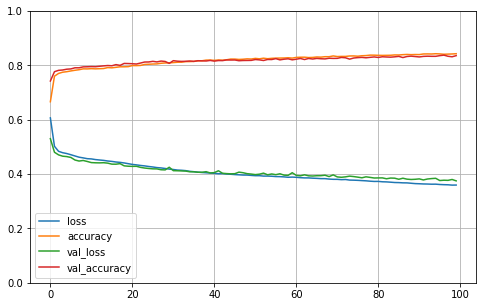

accuracy: 83.58%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 4, 100 epochs


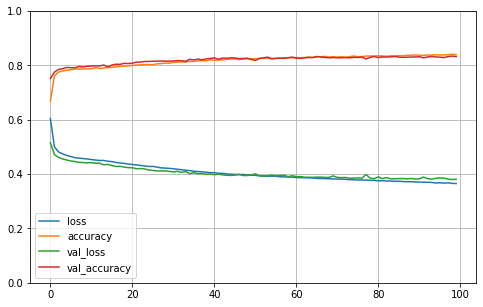

accuracy: 83.22%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Fold 5, 100 epochs


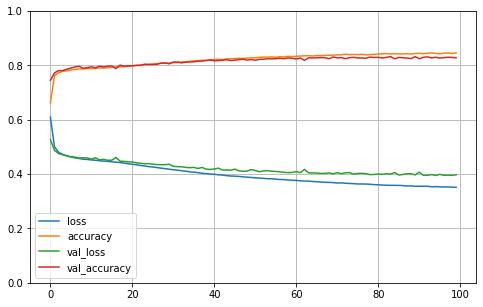

accuracy: 82.77%

Validation core mean 83.07% (+/- 0.34%)


In [7]:
rna_mer = read_features('ncRNA.3mer.features.csv','pcRNA.3mer.features.csv')
(train_set,test_set)=make_train_test(rna_mer)
(X_test,y_test)=prepare_data_set(test_set)
train_set=subset(train_set,200,3000)
(X_train_all,y_train_all)=prepare_data_set(train_set)
print(X_train_all.shape,y_train_all.shape)
do_cross_validation(X_train_all,y_train_all)